# PyBEL Demo

**Author:** [Charles Tapley Hoyt](https://github.com/cthoyt/)

This notebook demonstrates how to download a BEL file by URL, parse with `pybel`, and filter its data using the data structures provided by `networkx` and `pybel`.

In [1]:
from collections import Counter
import os, logging, time, math, shutil

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

import pybel
import pybel_tools
from pybel.constants import *
from pybel_tools import summary

%matplotlib inline

In [2]:
time.asctime()

'Sat Feb 25 13:41:29 2017'

In [3]:
pybel.__version__

'0.3.10-dev'

In [4]:
pybel_tools.__version__

'0.1.2-dev'

In [5]:
bms_base = os.environ.get('BMS_BASE', None)

## Data Acquisition

In these examples, `pybel` downloads the small and large corpra from the Selventa examples posted on the [BEL Framework](http://resource.belframework.org/belframework/1.0/knowledge). 

### Selventa Small Corpus

The Selventa [Small Corpus](http://resource.belframework.org/belframework/1.0/knowledge/small_corpus.bel) is distributed by OpenBEL and consists of approximately 2000 hand curated statements drawn from 57 PubMeds.

In [6]:
%%time

if bms_base and os.path.exists(os.path.join(bms_base, 'selventa', 'small_corpus.gpickle')):
    g = pybel.from_pickle(os.path.join(bms_base, 'selventa', 'small_corpus.gpickle'))
else:
    small_corpus_url = 'http://resource.belframework.org/belframework/1.0/knowledge/small_corpus.bel'
    g = pybel.from_url(small_corpus_url, allow_nested=True)  

CPU times: user 22.9 ms, sys: 7.7 ms, total: 30.6 ms
Wall time: 29.5 ms


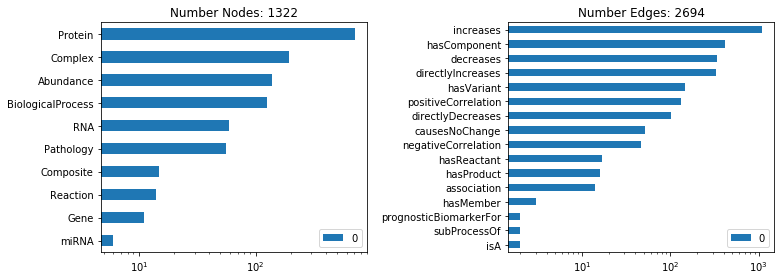

In [7]:
summary.plot_summary(g, plt)
plt.show()

/usr/local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


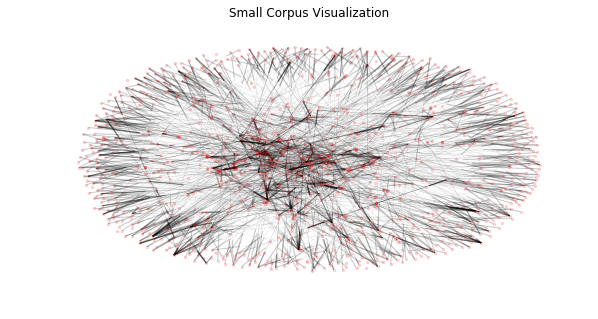

In [8]:
plt.figure(figsize=(10, 5))
plt.title('Small Corpus Visualization')
nx.draw_spring(g, 
               k=4/math.sqrt(len(g)),
               iterations=1000,
               node_size=5, 
               width=0.3,  
               alpha=0.15)

plt.show()

## Filtering Data

In addition to all of the wonderful ways one can interact with a `networkx` graph ([see tutorial](http://networkx.readthedocs.io/en/networkx-1.11/tutorial/tutorial.html)), `pybel` exposes the nodes and edges with simple filtering mechanisms. 

### Filtering Nodes by Data

Each node has a data dictionary attached to it. By default, this contains information about what type of entitity it is, what namespace and name it has, and other information.

In [10]:
human_genes = list(g.nodes_iter(**{FUNCTION: GENE, NAMESPACE:'HGNC'}))
', '.join('{}:{}'.format(n, v) for f, n, v in human_genes[:10])

'HGNC:VHL, HGNC:CCND1, HGNC:NCF1, HGNC:MYCN, HGNC:H1F0, HGNC:MPO, HGNC:ERBB2, HGNC:IGF2R, HGNC:CDK4, HGNC:DKK1'

If a sequence (`list`, `tuple`, or `set`) is given as the value, then nodes matching any of the elements of the sequence are returned.

In [11]:
human_and_mouse_genes = [n for n,d in g.nodes_iter(data=True) if NAMESPACE in d and d[NAMESPACE] in {'HGNC', 'MGI'}]
', '.join('{}:{}'.format(g.node[n][NAMESPACE], g.node[n][NAME]) for n in human_and_mouse_genes[:15])

'HGNC:NOS3, HGNC:NOS3, HGNC:SOD1, HGNC:CAT, HGNC:MYC, HGNC:F3, HGNC:F7, HGNC:F9, HGNC:F10, HGNC:F2, HGNC:TIMP3, HGNC:KDR, HGNC:AKT1, HGNC:AKT1, HGNC:AKT1'

### Filtering Edges by Data

Like the nodes, edges also have data associated to them. This can allow for filtering of edges by relation.

In [12]:
increases_edges = list(g.edges_iter(**{RELATION:INCREASES}))

increases_edges[:10]

[(('BiologicalProcess', 'GO', 'response to oxidative stress'),
  ('BiologicalProcess', 'GO', 'apoptotic process')),
 (('BiologicalProcess', 'GO', 'response to oxidative stress'),
  ('BiologicalProcess', 'GO', 'necrosis')),
 (('BiologicalProcess', 'GO', 'response to oxidative stress'),
  ('Pathology', 'SDIS', 'mitochondrial DNA damage')),
 (('BiologicalProcess', 'GO', 'response to oxidative stress'),
  ('Protein', 'HGNC', 'RALA')),
 (('BiologicalProcess', 'GO', 'response to oxidative stress'),
  ('Protein', 'PFH', 'FOXO Family')),
 (('BiologicalProcess', 'GO', 'response to oxidative stress'),
  ('Complex',
   ('Protein', 'HGNC', 'EP300'),
   ('Protein', 'PFH', 'FOXO Family'))),
 (('BiologicalProcess', 'GO', 'response to oxidative stress'),
  ('Complex',
   ('Protein', 'HGNC', 'CREBBP'),
   ('Protein', 'PFH', 'FOXO Family'))),
 (('BiologicalProcess', 'GO', 'response to oxidative stress'),
  ('Complex',
   ('Protein', 'HGNC', 'KAT2B'),
   ('Protein', 'PFH', 'FOXO Family'))),
 (('Biologica

If a dictionary is given as the argument, then it matches that subdictionary. Here, this allows for filtering edges where the subject's kinase activity is involved.

In [13]:
edge_subject_kinase = list(g.edges_iter(**{
    SUBJECT: {
        MODIFIER: ACTIVITY,
        EFFECT: {
            NAME: 'kin',
            NAMESPACE: BEL_DEFAULT_NAMESPACE
        },
    }
}))
                           
edge_subject_kinase[:10]

[(('Protein', 'HGNC', 'KDR'),
  ('Protein', 'HGNC', 'KDR', ('pmod', ('bel', 'Ph'), 'Tyr', 951))),
 (('Protein', 'HGNC', 'KDR'),
  ('Protein', 'HGNC', 'KDR', ('pmod', ('bel', 'Ph'), 'Tyr', 996))),
 (('Protein', 'HGNC', 'KDR'), ('Protein', 'HGNC', 'SRC')),
 (('Protein', 'HGNC', 'KDR'),
  ('Complex', 'NCH', 'p85/p110 PI3Kinase Complex')),
 (('Protein', 'HGNC', 'KDR'), ('Protein', 'PFH', 'AKT Family')),
 (('Protein', 'HGNC', 'AKT1'),
  ('Protein', 'HGNC', 'MTOR', ('pmod', ('bel', 'Ph')))),
 (('Protein', 'HGNC', 'AKT1'),
  ('Protein', 'PFH', 'FOXO Family', ('pmod', ('bel', 'Ph')))),
 (('Protein', 'HGNC', 'AKT1'), ('Protein', 'PFH', 'FOXO Family')),
 (('Protein', 'HGNC', 'AKT1'), ('Protein', 'PFH', 'FOXO Family')),
 (('Protein', 'HGNC', 'AKT1'),
  ('Complex', ('Protein', 'HGNC', 'AKT1'), ('Protein', 'HGNC', 'EP300')))]

# Conclusions

`pybel` allows for easy and fast loading of data from a variety of sources. Additionally, the shown method of filtering can become incredibly useful, especially when overlaying other data, such as differential gene expression labels (up, down, unregulated).